# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [51]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

## Preprocessing
We will be utilizing mostly KNN and tree-based algorithms. We will first turn categorical features to binary dummies.

In [53]:
# Turning all categorical features to dummies 
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [54]:
# Check if training and testing sets have the same features
if X_train.shape[1] != X_test.shape[1]:
    print('only in train:', [x for x in X_train.columns if x not in X_test.columns])
    print('only in test:',[x for x in X_test.columns if x not in X_train.columns])
else: 
    print ('Good to go')

Good to go


In [55]:
# If they are not the same, add the column with 0s and fix the order
# X_test[colname] = 0
# X_test = X_test[X_train.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, but in some cases where imbalance weight is not adequately dealt with by algorithm we test with resampled set using SMOTE.

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

## Evaluation Metrics
Our target is multi-class with imbalance issue. To focus on the imbalance of minority classes, we will also look at the macro f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average so naturally take class imbalance into account.

In [75]:
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report

## Feature Selection
To optimize the process, I will subset features based on a few random decision trees.

In [59]:
original_feats = X_train.columns
len(original_feats)

440

In [60]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [65]:
etc = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state = 23)
etc = etc.fit(X_train, y_train)
model = SelectFromModel(etc, prefit=True, threshold = 1e-4)

In [66]:
X_train_new = model.transform(X_train)
new_feats = original_feats[model.get_support()]

In [68]:
len(new_feats)

391

In [69]:
X_test_new = model.transform(X_test)

In [71]:
X_train = X_train_new
X_test = X_test_new

### Standardization
Since we will be testing kNN, all feature values need to be standardized.

In [72]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test= scale.transform(X_test)

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [73]:
scorer = {}

In [76]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train, y_train)
y_pred = dummyc.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)
f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
scorer['dummy'] = (accuracy, f1_test, ck_test)

Accuracy:  0.332 Test F1 score:  0.294 / Cohen Kappa:  -0.004


                         precision    recall  f1-score   support

             functional       0.54      0.34      0.41      4822
functional needs repair       0.07      0.29      0.11       678
         non functional       0.38      0.34      0.36      3410

               accuracy                           0.33      8910
              macro avg       0.33      0.32      0.29      8910
           weighted avg       0.44      0.33      0.37      8910



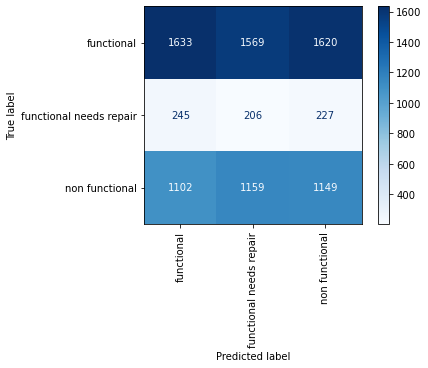

In [77]:
plot_confusion_matrix(dummyc, X_test, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 and less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.


## kNearestNeighbors
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Scoring Function
Function to return weighted F1 and balanced accuracy score

In [78]:
def scoring(y_test, y_pred, text, scorer = scorer):
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
    ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
    print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
    scorer[text] = (accuracy, f1_test, ck_test)
    return scorer

### kNN with GridSearchCV

Finding the optimal value for K using GridSearchCV.

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1_macro', verbose = 1, n_jobs = -1)
knc_g.fit(X_train, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test)
scoring(y_test, y_pred, 'knn gridsearch')
print(classification_report(y_test, y_pred))
# Test F1 score:  0.741 / Test Accuracy:  0.622
# Recall for functional needs repair: 0.32

In [ ]:
# saving the model 
mod = open('PKL/knn_gsc.pkl', 'wb')
pickle.dump(knc_g.best_estimator_, mod)
mod.close()
# Reload the model
#knc_g = pickle.load(open('PKL/knn_gsc.pkl', 'rb'))

### kNN with Optuna
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to be same as the time it took to complete GridSearch above.

In [ ]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train, y_train, scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

# initiating the optuna study
knn_study = optuna.create_study(direction='maximize')

# optimization process
knn_study.optimize(find_hyperp_KNN, timeout = 60*60)

In [ ]:
# saving the study 
mod = open('PKL/knn_study.pkl', 'wb')
pickle.dump(knn_study, mod)
mod.close()
# Reload the study
#knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [ ]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance')
knc_opt.fit(X_train, y_train)

y_pred = knc_opt.predict(X_test)
scoring(y_test, y_pred, 'knn optuna')
print(classification_report(y_test, y_pred))
# Test F1 score:  0.753 / Test Accuracy:  0.631
# functional needs repair recall = 0.32

Recall score for the needs repair class is still low but the overall performance and the recall for non-functional improved slightly.

In [ ]:
# saving the model
mod = open('PKL/knc_opt_model.pkl', 'wb')
pickle.dump(knc_opt, mod)
mod.close()

In [ ]:
#knc_study = pickle.load(open('PKL/knc_opt_model.pkl', 'rb'))

#### Simple kNN
Running kNN with default parameters

In [ ]:
knnSimple = KNeighborsClassifier(n_jobs = -1, )
knnSimple.fit(X_train, y_train)
y_pred = knnSimple.predict(X_test)

scoring(y_test, y_pred, 'knn_simple')
print(classification_report(y_test, y_pred))
# Test F1 score:  0.717 / Test Accuracy:  0.656
# needs repair recall = 0.54

Minority recall score has improved! let's try to optimize hyperparameters.

In [ ]:
mod = open('PKL/knnSimple.pkl', 'wb')
pickle.dump(knnSimple, mod)
mod.close()

In [ ]:
#knnSimple = pickle.load(open('PKL/knnSimple.pkl', 'rb'))

## Simple Decision Trees
Since we have a lot of features, tree-based model might deal better by ignoring less important features. We will first try with a simple tree.

In [ ]:
dtcSimple = DecisionTreeClassifier(class_weight = 'balanced', max_depth=6)
dtcSimple.fit(X_train, y_train)
y_pred_dtcSimple = dtcSimple.predict(X_test)
scoring(y_test, y_pred, 'decision tree simple')
print(classification_report(y_test, y_pred))
# Test F1 score:  0.728 / Test Accuracy:  0.642
# functional needs repair recall = 0.45

In [ ]:
# saving model
mod = open('PKL/dtcSimple.pkl', 'wb')
pickle.dump(dtcSimple, mod)
mod.close()

In [ ]:
#dtcSimple = pickle.load(open('PKL/dtcSimple.pkl', 'rb'))

About similar performance as kNN.

## Random Forest 
We will run random forest optimized by Optuna.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 100)
    min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 1e-7, 0.1)
    max_leaf_nodes= trial.suggest_int('max_leaf_nodes', 10, 100)
    rfc = RandomForestClassifier(oob_score = True, 
                                 n_estimators = n_estimators,
                                 max_depth = max_depth, 
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 criterion = criterion,
                                 class_weight = class_weight, 
                                 max_features = max_features,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf,
                                 max_leaf_nodes = max_leaf_nodes
                                )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train, y_train,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 60*30, n_trials = 100)

In [ ]:
rf = RandomForestClassifier(oob_score = True, **rfc_study.best_params)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
scoring(y_test, y_pred, 'random forest optuna')
print(classification_report(y_test, y_pred))
# Test F1 score:  0.731 / Test Accuracy:  0.694
# functional needs repair recall = 0.66

Much better performance in predicting the positive minority cases even though overall F1 score has dropped slightly. This model seems to be weighing the minority recall better. 

In [ ]:
# save the study
mod = open('PKL/rfc_study.pkl', 'wb')
pickle.dump(rfc_study, mod)
mod.close()
# Reload the study
#rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [ ]:
# save the model
mod = open('PKL/rf_model.pkl', 'wb')
pickle.dump(rf, mod)
mod.close()

In [ ]:
#rf_model = pickle.load(open('PKL/rf_model.pkl', 'rb'))

In [ ]:
# feature importance
rf_feats = pd.DataFrame(rf.feature_importances_,
                        index = X_train.columns,
                        columns=['feat_importance']).sort_values('feat_importance',ascending=False)
rf_feats.head(15)

## XGBoost
Now we'll try to run XGBoost with Optuna.

In [ ]:
import xgboost as xgb

In [ ]:
def find_hyperparam(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 15)
    #min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             #min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_res_scaled, y_train_res, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

#xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 60*60, n_trials = 100)

In [ ]:
# fitting and testing on the test set

xgbc = xgb.XGBClassifier(**xgb_study.best_params, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_res_scaled, y_train_res)
y_pred = xgbc.predict(X_test_scaled)    
scoring(y_test, y_pred)
# Test F1 score:  0.802 / Test Accuracy:  0.664
# functional needs repair recall = 0.31

Top majority classes are doing so much better, but the minority class recall score dropped significantly from random forest model. We'll try to oversampling the minority classes and try again.

In [ ]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()
# Reload the study
#xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [ ]:
# saving model
mod = open('PKL/xgbc_model.pkl', 'wb')
pickle.dump(xgbc, mod)
mod.close()

In [ ]:
#xgbc_model = pickle.load(open('PKL/xgbc_model.pkl', 'rb'))

## Voting Classifier
Now I will try to run a voting classifier using some of the above models. Since many of the models did better with with minority classes oversampled, I will use oversampled data for voting.

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_c_all = VotingClassifier(estimators = [('knc_g', knc_g), 
                                          ('knc_opt', knc_opt),
                                          ('knnSimple', knnSimple),
                                          ('knnOptuna', knnOptuna),
                                          ('dtcSimple', dtcSimple),
                                          ('rf', rf),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'soft', weights= [1, 1, 1, 1, 1, 2, 1],
                           n_jobs = -1)
voting_c_all.fit(X_train_res_scaled, y_train_res)

In [ ]:
y_pred = voting_c_all.predict(X_test_scaled)    
scoring(y_test, y_pred)

print(classification_report(y_test, y_pred))
# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Overall performance did not improve compare to random fores.

In [ ]:
# save model
mod = open('PKL/voting_equal_full.pkl', 'wb')
pickle.dump(voting_c_all, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_all = pickle.load(open('PKL/voting_equal_full.pkl', 'rb'))

## Logistic Regression with Lasso Regularization
Lastly we will look at running logistic regression with lasso penalty.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def find_hyperparam(trial):
    tol = trial.suggest_loguniform('tol', 1e-7, 1e-1)
    C = trial.suggest_float('C', 0.0001, 1)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    LogRegLasso = LogisticRegression(penalty = 'l1',
                                     tol = 'tol',
                                     C = 'C',
                                     solver = 'solver',
                                     max_iter = 'max_iter',
                                     class_weight = 'balanced')
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_res_scaled, y_train_res,
                                    scoring = 'balanced_accuracy', cv = cv,
                                    n_jobs = -1))
    return (score)

#l1_study = optuna.create_study(direction='maximize')
l1_study.optimize(find_hyperparam, timeout = 60*60, n_trials = 100)

In [ ]:
# fitting and testing on the test set

l1_mod = LogisticRegression(**l1_study.best_params, n_jobs = -1, verbose= 1)

l1_mod.fit(X_train_res_scaled, y_train_res)
y_pred = l1_mod.predict(X_test_scaled)
scoring(y_test, y_pred)
# Test F1 score:   / Test Accuracy:
# functional needs repair recall =

In [ ]:
# saving study
mod = open('PKL/l1_study.pkl', 'wb')
pickle.dump(l1_study, mod)
mod.close()

# saving model
mod = open('PKL/l1_mod.pkl', 'wb')
pickle.dump(l1_mod, mod)
mod.close()

## Final Voting with Logistic Regression
We will run the hard vote with logistic regression included.

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_c_all2 = VotingClassifier(estimators = [('knc_g', knc_g), 
                                          ('knc_opt', knc_opt),
                                          ('knnSimple', knnSimple),
                                          ('knnOptuna', knnOptuna),
                                          ('dtcSimple', dtcSimple),
                                          ('rf', rf),
                                          ('xgbc', xgbc),
                                          ('l1_mod', l1_mod),
                                         ], 
                            voting = 'soft',
                           n_jobs = -1)
voting_c_all2.fit(X_train_res_scaled, y_train_res)

In [ ]:
y_pred = voting_c_all2.predict(X_test_scaled)    
scoring(y_test, y_pred)

print(classification_report(y_test, y_pred))

In [ ]:
mod = open('PKL/voting_equal_full2.pkl', 'wb')
pickle.dump(voting_c_all2, mod)
mod.close()